# Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import eco2ai
from eco2ai import track
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Read file

In [6]:
df=pd.read_excel("df.xlsx")

In [7]:
float_col=[ 'GDP','Population', 'Scope 3 Purchased Goods and Industrials Emissions',
 'Scope 3 Capital Goods Emissions','Scope 3 Fuel & Energy Related Activities Emissions',
 'Scope 3 Upstream Transprttn and Distrbtn Emissions','Scope 3 Waste Generated in Operations Emissions',
 'Scope 3 Employee Commuting Emissions', 'Scope 3 Business Travel Emissions', 'Scope 3 Upstream Leased Assets Emissions',
 'Scope 3 Dwnstrm Transprttn and Distrbtn Emissions','Scope 3 Processing of Sold Products Emissions',
 'Scope 3 Use of Sold Products Emissions', 'Scope 3 EOL Treatment of Sold Products Emissions',
 'Scope 3 Downstream Leased Assets Emissions', 'Scope 3 Emissions from Franchises',
 'Scope 3 Emissions from Investments','Scope 3 Emissions Other','Scope 3_total',
 'ESG News Sentiment ES Positive', 'ESG Disclosure Score',
 'Number of Employees',
 'Total Assets', 'Capital Expenditures',
 'Operating Expenses', 'SGA expense',
 'Cost of Goods & Industrials Sold','Inventories', 'Revenue',
 'Property Plant & Equipment Net','Asset Turnover', 'Inventory Turnover',
 'Emission scope 1', 'Emission scope 2']
object_col = ['Company', 'Ticker','Country']
cat_col=['Year','Sector', 'Carbon tax', 'CSR/Sustainability Committee']

In [11]:
#df.info()

# 1. Processing

In [8]:
#change type
df[float_col]=df[float_col].astype(float)
df[object_col]=df[object_col].astype(str)
df[cat_col]=df[cat_col].astype('category')

# remove negative values
r_index= df[(df['Revenue']<0) | (df['Scope 3 Emissions Other']<0) | (df['Asset Turnover']<0) | (df['Inventory Turnover']<0)].index
df.drop(r_index , inplace=True)

### Replace 0 with NA

In [9]:
#repalce 0 with NA
noreplace0_col=['Scope 3 Purchased Goods and Industrials Emissions',
 'Scope 3 Capital Goods Emissions','Scope 3 Fuel & Energy Related Activities Emissions',
 'Scope 3 Upstream Transprttn and Distrbtn Emissions','Scope 3 Waste Generated in Operations Emissions',
 'Scope 3 Employee Commuting Emissions', 'Scope 3 Business Travel Emissions', 'Scope 3 Upstream Leased Assets Emissions',
 'Scope 3 Dwnstrm Transprttn and Distrbtn Emissions','Scope 3 Processing of Sold Products Emissions',
 'Scope 3 Use of Sold Products Emissions', 'Scope 3 EOL Treatment of Sold Products Emissions',
 'Scope 3 Downstream Leased Assets Emissions', 'Scope 3 Emissions from Franchises',
 'Scope 3 Emissions from Investments','Scope 3 Emissions Other','Emission scope 1', 'Emission scope 2', 'ESG News Sentiment ES Positive','ESG Disclosure Score']
replace_na=[col for col in float_col if col not in noreplace0_col]
len(replace_na)           
df[replace_na]=df[replace_na].replace(0, np.nan)

### Remove nan in Scope 3 total

In [10]:
#remove nan in Scope 3_total
df = df[~df['Scope 3_total'].isnull()]

### Outliers

In [11]:
emission_col=['Scope 3 Purchased Goods and Industrials Emissions',
 'Scope 3 Capital Goods Emissions','Scope 3 Fuel & Energy Related Activities Emissions',
 'Scope 3 Upstream Transprttn and Distrbtn Emissions','Scope 3 Waste Generated in Operations Emissions',
 'Scope 3 Employee Commuting Emissions', 'Scope 3 Business Travel Emissions', 'Scope 3 Upstream Leased Assets Emissions',
 'Scope 3 Dwnstrm Transprttn and Distrbtn Emissions','Scope 3 Processing of Sold Products Emissions',
 'Scope 3 Use of Sold Products Emissions', 'Scope 3 EOL Treatment of Sold Products Emissions',
 'Scope 3 Downstream Leased Assets Emissions', 'Scope 3 Emissions from Franchises',
 'Scope 3 Emissions from Investments','Scope 3 Emissions Other','Scope 3_total','Emission scope 1', 'Emission scope 2']
top_quantiles = df[emission_col].quantile(0.99)
outliers_top = (df[emission_col] > top_quantiles)
df[emission_col] = df[emission_col].mask(outliers_top, top_quantiles, axis=1)

### Encoding

In [12]:
df= pd.get_dummies(df, columns = ["Sector"], drop_first=True, dtype=int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6734 entries, 0 to 8579
Data columns (total 50 columns):
 #   Column                                              Non-Null Count  Dtype   
---  ------                                              --------------  -----   
 0   Year                                                6734 non-null   category
 1   Company                                             6734 non-null   object  
 2   Ticker                                              6734 non-null   object  
 3   Country                                             6734 non-null   object  
 4   GDP                                                 6734 non-null   float64 
 5   Population                                          6734 non-null   float64 
 6   Carbon tax                                          6734 non-null   category
 7   Scope 3 Purchased Goods and Industrials Emissions   3627 non-null   float64 
 8   Scope 3 Capital Goods Emissions                     2044 non-null   

# 2.Split data

In [13]:
X = df.copy(deep=True)
y = X.pop('Scope 3_total').values.reshape(-1,1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size = .2)

# 3.Impute

In [15]:
fl_col=float_col.copy()
fl_col.remove('Scope 3_total')

In [16]:
def imputation(X_train, X_test, impute_method):
    tracker = eco2ai.Tracker(
    project_name="Imputation", 
    experiment_description=f"{impute_method} imputation",
    file_name="emission_imputation.csv",
    )
    tracker.start()
    X_train_imputed=X_train.copy(deep=True)
    X_test_imputed=X_test.copy(deep=True)
    imp=impute_method
    imp.fit(X_train_imputed[fl_col])
    X_train_imputed.loc[:, fl_col]=imp.transform(X_train_imputed[fl_col])
    X_test_imputed.loc[:, fl_col]=imp.transform(X_test_imputed[fl_col])
    tracker.stop()
    return X_train_imputed, X_test_imputed

In [17]:
X_train_iknn, X_test_iknn = imputation(X_train, X_test, KNNImputer(n_neighbors=4))
X_train_ii, X_test_ii = imputation(X_train, X_test, IterativeImputer(estimator=RandomForestRegressor(),random_state=2023, n_nearest_features=3, initial_strategy='median'))
X_train_si, X_test_si= imputation(X_train, X_test, SimpleImputer(strategy='median'))

# 4. Scale+Model

In [18]:
scale_cols=['Scope 3 Purchased Goods and Industrials Emissions',
 'Scope 3 Capital Goods Emissions','Scope 3 Fuel & Energy Related Activities Emissions',
 'Scope 3 Upstream Transprttn and Distrbtn Emissions','Scope 3 Waste Generated in Operations Emissions',
 'Scope 3 Employee Commuting Emissions', 'Scope 3 Business Travel Emissions', 'Scope 3 Upstream Leased Assets Emissions',
 'Scope 3 Dwnstrm Transprttn and Distrbtn Emissions','Scope 3 Processing of Sold Products Emissions',
 'Scope 3 Use of Sold Products Emissions', 'Scope 3 EOL Treatment of Sold Products Emissions',
 'Scope 3 Downstream Leased Assets Emissions', 'Scope 3 Emissions from Franchises',
 'Scope 3 Emissions from Investments','Scope 3 Emissions Other','GDP', 'Population', 'Number of Employees', 'Total Assets', 'Capital Expenditures',
       'Operating Expenses', 'SGA expense', 'Cost of Goods & Industrials Sold',
       'Inventories', 'Revenue', 'Property Plant & Equipment Net',
       'Asset Turnover', 'Inventory Turnover', 'Emission scope 1',
       'Emission scope 2']
drop_col=['Scope 3 Purchased Goods and Industrials Emissions',
 'Scope 3 Capital Goods Emissions','Scope 3 Fuel & Energy Related Activities Emissions',
 'Scope 3 Upstream Transprttn and Distrbtn Emissions','Scope 3 Waste Generated in Operations Emissions',
 'Scope 3 Employee Commuting Emissions', 'Scope 3 Business Travel Emissions', 'Scope 3 Upstream Leased Assets Emissions',
 'Scope 3 Dwnstrm Transprttn and Distrbtn Emissions','Scope 3 Processing of Sold Products Emissions',
 'Scope 3 Use of Sold Products Emissions', 'Scope 3 EOL Treatment of Sold Products Emissions',
 'Scope 3 Downstream Leased Assets Emissions', 'Scope 3 Emissions from Franchises',
 'Scope 3 Emissions from Investments','Scope 3 Emissions Other','Ticker','Country','Company']

In [21]:
class buildmodel:
    def __init__(self, X_train, X_test, y_train, y_test, y_test_ori):
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        self.y_test_ori=y_test_ori
        
    #scale X    
    def scaleX(self, X_scale):
        X_scale=X_scale
        X_scale.fit(self.X_train[scale_cols])
        self.X_train[scale_cols]=X_scale.transform(self.X_train[scale_cols])
        self.X_test[scale_cols]=X_scale.transform(self.X_test[scale_cols])
        self.X_train=self.X_train.drop(columns=drop_col)
        self.X_test=self.X_test.drop(columns=drop_col)
        return self
        
    
    def scaley(self, y_scale):
        y_scale=y_scale
        y_scale.fit(self.y_train)
        self.y_train=y_scale.transform(self.y_train)
        self.y_test=y_scale.transform(self.y_test)
        return y_scale


    def model(self, model):     
        y_scale=self.scaley(MinMaxScaler())

        
        #fit model
        tracker = eco2ai.Tracker(
        project_name="model", 
        experiment_description=f"{model}",
        file_name="emission_training.csv",)
        tracker.start()
        reg = model
        reg.fit(self.X_train, self.y_train)
        tracker.stop()

        # predict
        y_predict_std = reg.predict(self.X_test)

        # convert to original scale
        y_predict = y_scale.inverse_transform(y_predict_std.reshape(-1,1))

        print(f'MSE is {mean_squared_error(self.y_test_ori, y_predict)}')
        print(f'RMSE is {mean_squared_error(self.y_test_ori, y_predict)**0.5}')
        print(f'Rsquared is {r2_score(self.y_test_ori, y_predict)}')
        return reg

# KNN data set 

In [22]:
#Linear
knn_model_linear=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_linear.scaleX(MinMaxScaler())
knn_model_linear.model(LinearRegression())

LinearRegression()
MSE is 1265577096.63145
MRSE is 35574.95040940254
Rsquared is 0.3616350939794264


LinearRegression()

In [23]:
#Knn
knn_model_knn=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_knn.scaleX(MinMaxScaler())
knn_model_knn.model(KNeighborsRegressor(n_neighbors=3))

KNeighborsRegressor(n_neighbors=3)
MSE is 1964370949.5704205
MRSE is 44321.22459466142
Rsquared is 0.009159157549734842


KNeighborsRegressor(n_neighbors=3)

In [24]:
#random forest
knn_model_rf=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_rf.scaleX(MinMaxScaler())
knn_model_rf.model(RandomForestRegressor(random_state=2023))

RandomForestRegressor(random_state=2023)
MSE is 428616340.2251551
MRSE is 20703.051471344872
Rsquared is 0.7838032700852576


RandomForestRegressor(random_state=2023)

In [25]:
#Adaboost
knn_model_ada=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_ada.scaleX(MinMaxScaler())
knn_model_ada.model(AdaBoostRegressor(random_state=2023))

AdaBoostRegressor(random_state=2023)
MSE is 1430180858.0242054
MRSE is 37817.732058178815
Rsquared is 0.2786079398441308


AdaBoostRegressor(random_state=2023)

In [26]:
#Extra trees regression 
knn_model_etr=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_etr.scaleX(MinMaxScaler())
extra_tree = knn_model_etr.model(ExtraTreesRegressor(random_state=2023))

ExtraTreesRegressor(random_state=2023)
MSE is 247583527.86797667
MRSE is 15734.787188518842
Rsquared is 0.8751173390223665


In [27]:
#GradientBoostingRegressor
knn_model_gbr=buildmodel(X_train_iknn, X_test_iknn, y_train, y_test, y_test)
knn_model_gbr.scaleX(MinMaxScaler())
knn_model_gbr.model(GradientBoostingRegressor(random_state=2023))

GradientBoostingRegressor(random_state=2023)
MSE is 662972813.0440207
MRSE is 25748.25844681579
Rsquared is 0.6655924173884702


GradientBoostingRegressor(random_state=2023)

### ITERATIVE IMPUTATION

In [46]:
#lINEAR
iterative_linear=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_linear.scaleX(MinMaxScaler())
iterative_linear.model(LinearRegression())

MSE is 1249291811.7632582
MRSE is 35345.32234629157
Rsquared is 0.36984949227414265


LinearRegression()

In [47]:
#KNN
iterative_knn=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_knn.scaleX(MinMaxScaler())
iterative_knn.model(KNeighborsRegressor(n_neighbors=3))

MSE is 1909337168.2219095
MRSE is 43695.962836650135
Rsquared is 0.03691853684950874
MRSLE is 11.118328598172962


KNeighborsRegressor(n_neighbors=3)

In [48]:
#Random Forest
iterative_rf=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_rf.scaleX(MinMaxScaler())
iterative_rf.model(RandomForestRegressor(random_state=2023))

MSE is 477726994.31578946
MRSE is 21856.966722667385
Rsquared is 0.7590315527662406
MRSLE is 9.397459836295194


RandomForestRegressor(random_state=2023)

In [49]:
#AdaBoost
iterative_ada=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_ada.scaleX(MinMaxScaler())
iterative_ada.model(AdaBoostRegressor(random_state=2023))

MSE is 1482327242.5196843
MRSE is 38501.00313653768
Rsquared is 0.25230498135478074
MRSLE is 23.64446308252839


AdaBoostRegressor(random_state=2023)

In [50]:
# Extra tree
iterative_etr=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_etr.scaleX(MinMaxScaler())
iterative_etr.model(ExtraTreesRegressor(n_estimators=200, random_state=2023))

MSE is 281289359.66693544
MRSE is 16771.683268740064
Rsquared is 0.8581159092351511
MRSLE is 7.77218916959162


ExtraTreesRegressor(n_estimators=200, random_state=2023)

In [51]:
# Gradient Boosting
iterative_gbr=buildmodel(X_train_ii, X_test_ii, y_train, y_test, y_test)
iterative_gbr.scaleX(MinMaxScaler())
iterative_gbr.model(GradientBoostingRegressor(random_state=2023))

MSE is 671325750.5302477
MRSE is 25909.95466090683
Rsquared is 0.6613791441176567


GradientBoostingRegressor(random_state=2023)

### SIMPLE IMPUTATION

In [28]:
# LINEAR
simple_linear=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_linear.scaleX(MinMaxScaler())
simple_linear.model(LinearRegression())

LinearRegression()
MSE is 1231024779.7161477
MRSE is 35085.962716108384
Rsquared is 0.37906349608873957


LinearRegression()

In [29]:
# KNN
simple_knn=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_knn.scaleX(MinMaxScaler())
simple_knn.model(KNeighborsRegressor(n_neighbors=3))

KNeighborsRegressor(n_neighbors=3)
MSE is 1916146702.34108
MRSE is 43773.812974666485
Rsquared is 0.03348376577187284


KNeighborsRegressor(n_neighbors=3)

In [30]:
# RANDOM FOREST
simple_rf = buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_rf.scaleX(MinMaxScaler())
simple_rf.model(RandomForestRegressor(random_state=2023))

RandomForestRegressor(random_state=2023)
MSE is 398391572.42017484
MRSE is 19959.748806539996
Rsquared is 0.7990488296886001


RandomForestRegressor(random_state=2023)

In [31]:
# ADABOOST
simple_ada=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_ada.scaleX(MinMaxScaler())
simple_ada.model(AdaBoostRegressor(random_state=2023))

AdaBoostRegressor(random_state=2023)
MSE is 1183747036.0124574
MRSE is 34405.625063533684
Rsquared is 0.40291068208523195


AdaBoostRegressor(random_state=2023)

In [32]:
# EXTRA TREES 
simple_etr=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_etr.scaleX(MinMaxScaler())
simple_etr.model(ExtraTreesRegressor(n_estimators=100, random_state=2023))

ExtraTreesRegressor(random_state=2023)
MSE is 249154353.06997877
MRSE is 15784.623944522047
Rsquared is 0.8743250050862359


ExtraTreesRegressor(random_state=2023)

In [33]:
# GRADIENT BOOSTING
simple_gbr=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
simple_gbr.scaleX(MinMaxScaler())
simple_gbr.model(GradientBoostingRegressor(random_state=2023))

GradientBoostingRegressor(random_state=2023)
MSE is 633832345.3754117
MRSE is 25176.027196033367
Rsquared is 0.6802910493044397


GradientBoostingRegressor(random_state=2023)

# 5.Overfitting

### Train-Test split

In [39]:
train_scores_rf, test_scores_rf= list(), list()
values= [i for i in range(1, 21)]

In [40]:
for i in values:
    print(f'max_depth = {i}')
    simple_etr=buildmodel(X_train_si, X_test_si, y_train, y_test, y_test)
    simple_etr.scaleX(MinMaxScaler())
    reg=simple_etr.model(RandomForestRegressor(random_state=2023,  max_depth=i))
    train_scores_rf.append(r2_score(simple_etr.y_train, reg.predict(simple_etr.X_train)))
    test_scores_rf.append(r2_score(simple_etr.y_test, reg.predict(simple_etr.X_test)))
    print('R_squared_train: ', r2_score(simple_etr.y_train, reg.predict(simple_etr.X_train)))
    print('R_squared_test: ', r2_score(simple_etr.y_test, reg.predict(simple_etr.X_test)))
    print('................')

max_depth = 1
RandomForestRegressor(max_depth=1, random_state=2023)
MSE is 1524848431.0455208
MRSE is 39049.30768970842
Rsquared is 0.23085703117503498
R_squared_train:  0.23203747128876395
R_squared_test:  0.23085703117503498
................
max_depth = 2
RandomForestRegressor(max_depth=2, random_state=2023)
MSE is 1248032778.1814172
MRSE is 35327.50738704073
Rsquared is 0.3704845565908784
R_squared_train:  0.3792554736757705
R_squared_test:  0.37048455659087853
................
max_depth = 3
RandomForestRegressor(max_depth=3, random_state=2023)
MSE is 990846556.1733178
MRSE is 31477.715231149126
Rsquared is 0.5002108758162946
R_squared_train:  0.4893189793566741
R_squared_test:  0.5002108758162946
................
max_depth = 4
RandomForestRegressor(max_depth=4, random_state=2023)
MSE is 814941669.262446
MRSE is 28547.183210650506
Rsquared is 0.5889383874789988
R_squared_train:  0.58138184940058
R_squared_test:  0.5889383874789988
................
max_depth = 5
RandomForestRegressor

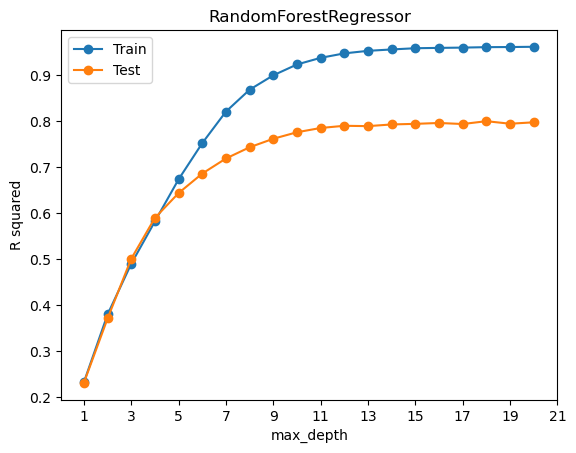

In [41]:
plt.plot(values, train_scores_rf, '-o', label='Train')
plt.plot(values, test_scores_rf, '-o', label='Test')


plt.legend()
plt.xticks(range(1, 22, 2))
plt.xlabel('max_depth')
plt.ylabel('R squared')
plt.title('RandomForestRegressor')
plt.show()

### Kfold

In [37]:
cross_test_scores_et, cross_train_scores_et = list(), list()

In [38]:
for i in values:
    reg_et = ExtraTreesRegressor(random_state=2023, max_depth=i)
    scoring = 'r2'
    lnr_score_et = cross_validate(reg_et, simple_etr.X_train, simple_etr.y_train, scoring = scoring, cv = 10, return_estimator = False, return_train_score=True)
    
    print(".........................")
    print("max_depth = ", i)
    cross_test_scores_et.append(lnr_score_et["test_score"].mean())
    cross_train_scores_et.append(lnr_score_et["train_score"].mean())

.........................
max_depth =  1
.........................
max_depth =  2
.........................
max_depth =  3
.........................
max_depth =  4
.........................
max_depth =  5
.........................
max_depth =  6
.........................
max_depth =  7
.........................
max_depth =  8
.........................
max_depth =  9
.........................
max_depth =  10
.........................
max_depth =  11
.........................
max_depth =  12
.........................
max_depth =  13
.........................
max_depth =  14
.........................
max_depth =  15
.........................
max_depth =  16
.........................
max_depth =  17
.........................
max_depth =  18
.........................
max_depth =  19
.........................
max_depth =  20


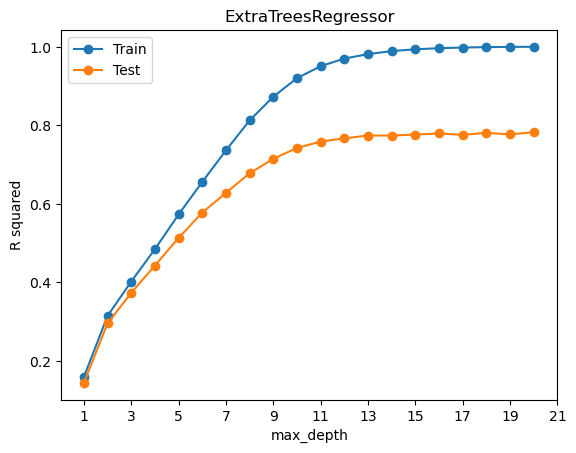

In [40]:
plt.plot(values, cross_train_scores_et, '-o', label='Train')
plt.plot(values, cross_test_scores_et, '-o', label='Test')


plt.legend()
plt.xticks(range(1, 22, 2))
plt.xlabel('max_depth')
plt.ylabel('R squared')
plt.title('ExtraTreesRegressor')
plt.show()